In [1]:
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import pandas as pd
from datetime import date
from CanaryFinancialCalculations import CanaryFinancialCalculations 
import cvxpy as cp
import hvplot.pandas
import warnings
from bokeh.models import HoverTool
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats

In [2]:
warnings.filterwarnings('ignore')

In [3]:
alpaca_api_key = 'PK306FA7SFOSMY9LBUZ4'
alpaca_secret_key = 'oNujbWMi3ZLrZuVggRN1DnZBLs38EJO00cwyOgsE'
base_url = 'https://paper-api.alpaca.markets'

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url,
    api_version="v2")

tickers = ["AZO", "NFLX", "AMD", "BKNG"]
benchmark= ["SPY", "QQQ", "PSI", "IGM"]
timeframe = '1Day'
initial_investment = 10000
weights = [(1 / len(tickers))] * len(tickers)
weights_benchmark = [(1 / len(benchmark))] * len(benchmark)

start_date = pd.Timestamp("2018-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-01", tz="America/New_York").isoformat()

portfolio_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df


# User Portfolio

In [4]:
portfolio_df = portfolio_df.pivot(columns='symbol', values='close')
portfolio_df

symbol,AMD,AZO,BKNG,NFLX
timestamp,,,,
2018-01-02 05:00:00+00:00,10.98,736.54,1784.75,201.070
2018-01-03 05:00:00+00:00,11.55,749.43,1824.16,205.050
2018-01-04 05:00:00+00:00,12.12,761.26,1807.25,205.630
2018-01-05 05:00:00+00:00,11.88,775.50,1823.54,209.990
2018-01-08 05:00:00+00:00,12.28,766.48,1851.81,212.050
...,...,...,...,...
2022-12-23 05:00:00+00:00,64.52,2430.65,1971.52,294.965
2022-12-27 05:00:00+00:00,63.27,2454.32,1998.27,284.170
2022-12-28 05:00:00+00:00,62.57,2461.63,1958.84,276.880


In [5]:
portfolio_added = portfolio_df
portfolio_added = portfolio_added.dot(weights)
portfolio_added_df = pd.DataFrame(portfolio_added)
portfolio_added_df.columns = ['Portfolio']
portfolio_added_df.index = portfolio_added_df.index.date
portfolio_added_df.index.name='Date'
portfolio_added_df

,Portfolio
Date,
2018-01-02,683.33500
2018-01-03,697.54750
2018-01-04,696.56500
2018-01-05,705.22750
2018-01-08,710.65500
...,...
2022-12-23,1190.41375
2022-12-27,1200.00750
2022-12-28,1189.98000


In [6]:

portfolio_df_pct = portfolio_df.pct_change()
portfolio_df_pct.index = portfolio_df_pct.index.date
portfolio_df_pct = portfolio_df_pct.dropna()
portfolio_df_pct.index.name='Date'
portfolio_df_pct

symbol,AMD,AZO,BKNG,NFLX
Date,,,,
2018-01-03,0.051913,0.017501,0.022082,0.019794
2018-01-04,0.049351,0.015785,-0.009270,0.002829
2018-01-05,-0.019802,0.018706,0.009014,0.021203
2018-01-08,0.033670,-0.011631,0.015503,0.009810
2018-01-09,-0.037459,0.005832,0.007279,-0.012921
...,...,...,...,...
2022-12-23,0.010335,0.011145,0.019933,-0.009353
2022-12-27,-0.019374,0.009738,0.013568,-0.036598
2022-12-28,-0.011064,0.002978,-0.019732,-0.025654


In [7]:
user_returns = portfolio_df_pct.dot(weights)
user_returns_df = pd.DataFrame(user_returns)
user_returns_df.columns = ['Portfolio']
user_returns_df

,Portfolio
Date,
2018-01-03,0.027822
2018-01-04,0.014674
2018-01-05,0.007280
2018-01-08,0.011838
2018-01-09,-0.009317
...,...
2022-12-23,0.008015
2022-12-27,-0.008166
2022-12-28,-0.013368


# Benchmark Dataframe

In [8]:
benchmark_df = alpaca.get_bars(
    benchmark,
    timeframe,
    start=start_date,
    end=end_date
).df


In [9]:
benchmark_df = benchmark_df.pivot(columns='symbol', values='close')
benchmark_df_pct = benchmark_df.pct_change()
benchmark_df_pct.index = benchmark_df_pct.index.date
benchmark_df_pct = benchmark_df_pct.dropna()
benchmark_df_pct.index.name='Date'
benchmark_df_pct

symbol,IGM,PSI,QQQ,SPY
Date,,,,
2018-01-03,0.012274,0.015632,0.009717,0.006325
2018-01-04,0.005081,0.006853,0.001750,0.004067
2018-01-05,0.010765,0.007918,0.010043,0.006739
2018-01-08,0.006456,0.008427,0.003891,0.001865
2018-01-09,-0.002428,-0.013928,0.000062,0.002264
...,...,...,...,...
2022-12-23,0.002794,-0.001020,0.002249,0.005752
2022-12-27,-0.011576,-0.015210,-0.014138,-0.003943
2022-12-28,-0.014061,-0.016380,-0.013203,-0.012428


In [10]:
benchmark_df.index = benchmark_df.index.date
benchmark_df.index.name='Date'
benchmark_df

symbol,IGM,PSI,QQQ,SPY
Date,,,,
2018-01-02,171.100,51.8100,158.49,268.77
2018-01-03,173.200,52.6199,160.03,270.47
2018-01-04,174.080,52.9805,160.31,271.57
2018-01-05,175.954,53.4000,161.92,273.40
2018-01-08,177.090,53.8500,162.55,273.91
...,...,...,...,...
2022-12-23,279.900,100.4275,267.36,382.91
2022-12-27,276.660,98.9000,263.58,381.40
2022-12-28,272.770,97.2800,260.10,376.66


In [11]:
benchmark_returns = benchmark_df_pct.dot(weights_benchmark)
benchmark_returns = pd.DataFrame(benchmark_returns)
benchmark_returns.columns = ['Benchmark']
benchmark_returns

,Benchmark
Date,
2018-01-03,0.010987
2018-01-04,0.004438
2018-01-05,0.008866
2018-01-08,0.005160
2018-01-09,-0.003508
...,...
2022-12-23,0.002444
2022-12-27,-0.011217
2022-12-28,-0.014018


# Combining Portfolio and SPY

In [12]:
comparing_portfolios = pd.concat([user_returns_df, benchmark_df_pct], axis=1, join='inner')
comparing_portfolios

,Portfolio,IGM,PSI,QQQ,SPY
Date,,,,,
2018-01-03,0.027822,0.012274,0.015632,0.009717,0.006325
2018-01-04,0.014674,0.005081,0.006853,0.001750,0.004067
2018-01-05,0.007280,0.010765,0.007918,0.010043,0.006739
2018-01-08,0.011838,0.006456,0.008427,0.003891,0.001865
2018-01-09,-0.009317,-0.002428,-0.013928,0.000062,0.002264
...,...,...,...,...,...
2022-12-23,0.008015,0.002794,-0.001020,0.002249,0.005752
2022-12-27,-0.008166,-0.011576,-0.015210,-0.014138,-0.003943
2022-12-28,-0.013368,-0.014061,-0.016380,-0.013203,-0.012428


# Cumulative Returns

In [13]:
user_cumulative_returns = CanaryFinancialCalculations.cumulative_returns(user_returns_df, initial_investment)
user_cumulative_returns

,Profit
Date,
2018-01-03,10278.222352
2018-01-04,10429.041229
2018-01-05,10504.966412
2018-01-08,10629.323239
2018-01-09,10530.285729
...,...
2022-12-23,30434.741712
2022-12-27,30186.203601
2022-12-28,29782.681979


In [ ]:
## change this to be each benchmarks returns 

In [14]:
benchmark_returns = CanaryFinancialCalculations.cumulative_returns(benchmark_returns, initial_investment)
benchmark_returns

,Profit
Date,
2018-01-03,10109.868634
2018-01-04,10154.732234
2018-01-05,10244.766143
2018-01-08,10297.627620
2018-01-09,10261.506931
...,...
2022-12-23,17004.045510
2022-12-27,16813.314252
2022-12-28,16577.627392


# Correlation

In [15]:
user_rolling_correlation = CanaryFinancialCalculations.rolling_correlation(comparing_portfolios)
user_rolling_correlation

Portfolio       IGM       PSI       QQQ       SPY
Date                                                                   
2018-01-17 Portfolio   1.000000  0.710385  0.590776  0.568607  0.488575
           IGM         0.710385  1.000000  0.886403  0.960664  0.877161
           PSI         0.590776  0.886403  1.000000  0.801035  0.707211
           QQQ         0.568607  0.960664  0.801035  1.000000  0.927778
           SPY         0.488575  0.877161  0.707211  0.927778  1.000000
...                         ...       ...       ...       ...       ...
2022-12-30 Portfolio   1.000000  0.975883  0.977769  0.980200  0.936272
           IGM         0.975883  1.000000  0.975795  0.995332  0.929317
           PSI         0.977769  0.975795  1.000000  0.983508  0.881051
           QQQ         0.980200  0.995332  0.983508  1.000000  0.919395
           SPY         0.936272  0.929317  0.881051  0.919395  1.000000

[6245 rows x 5 columns]

In [16]:
user_correlation = CanaryFinancialCalculations.correlation(comparing_portfolios)
user_correlation

,Portfolio,IGM,PSI,QQQ,SPY
Portfolio,1.000000,0.853082,0.785103,0.844599,0.810579
IGM,0.853082,1.000000,0.878513,0.989431,0.925076
PSI,0.785103,0.878513,1.000000,0.868822,0.828351
QQQ,0.844599,0.989431,0.868822,1.000000,0.929960
SPY,0.810579,0.925076,0.828351,0.929960,1.000000


# Covariance

In [17]:
user_covariance = CanaryFinancialCalculations.covariance(comparing_portfolios, "Portfolio", "SPY")
user_covariance

Date
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
2018-01-09         NaN
                ...   
2022-12-23    0.000219
2022-12-27    0.000220
2022-12-28    0.000219
2022-12-29    0.000248
2022-12-30    0.000166
Length: 1258, dtype: float64

# Variance

In [18]:
user_variance = CanaryFinancialCalculations.variance(comparing_portfolios, "SPY")
user_variance

Date
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
2018-01-09         NaN
                ...   
2022-12-23    0.000175
2022-12-27    0.000175
2022-12-28    0.000171
2022-12-29    0.000190
2022-12-30    0.000134
Name: SPY, Length: 1258, dtype: float64

# Beta

In [19]:
user_beta = CanaryFinancialCalculations.beta(user_covariance, user_variance)
user_beta

,Beta
Date,
2018-02-01,1.183638
2018-02-02,1.139588
2018-02-05,1.086309
2018-02-06,1.083101
2018-02-07,1.079957
...,...
2022-12-23,1.252632
2022-12-27,1.256542
2022-12-28,1.281794


# Drawdown

In [20]:
user_daily_drawdown = CanaryFinancialCalculations.daily_drawdown(portfolio_added_df)
user_daily_drawdown

,Portfolio
Date,
2018-01-02,0.00
2018-01-03,2.04
2018-01-04,2.04
2018-01-05,3.10
2018-01-08,3.84
...,...
2022-12-23,57.19
2022-12-27,57.19
2022-12-28,57.19


# Annual Returns

In [21]:
user_annual_returns = CanaryFinancialCalculations.annual_return(portfolio_added_df, 'Portfolio')
user_annual_returns

12.111524656294836

In [37]:
benchmark_annual_return = CanaryFinancialCalculations.annual_return(benchmark_df, 'SPY')
benchmark_annual_return

7.308526750062572

# Tracking Error

In [23]:
user_tracking_error = CanaryFinancialCalculations.tracking_error(user_annual_returns, benchmark_annual_return)
user_tracking_error

4.802997906232265

# Sharpe Ratio

In [24]:
user_sharpe_ratio = CanaryFinancialCalculations.sharpe_ratio(user_returns_df)
user_sharpe_ratio

,Sharpe Ratio
Portfolio,0.888538


# Return on Investment

In [25]:
user_roi = CanaryFinancialCalculations.return_on_investment(user_cumulative_returns, 'Profit', initial_investment)
user_roi = user_roi.round(2)
user_roi

207.55

In [39]:
benchmark_roi = CanaryFinancialCalculations.return_on_investment(benchmark_returns, 'Profit', initial_investment)
benchmark_roi = benchmark_roi.round(2)
benchmark_roi

69.69

In [ ]:
## change this to have all benchmarks 

In [27]:
compared_roi = pd.DataFrame({
    'Compared': ['Portfolio', 'SPY'],
    'Percentage': [user_roi, benchmark_roi]
})
compared_roi

,Compared,Percentage
0,Portfolio,207.55
1,SPY,69.69


# Standard Deviation

In [28]:
user_std = CanaryFinancialCalculations.standard_deviation(user_returns_df)
user_std

,Portfolio
Date,
2018-02-01,0.012578
2018-02-02,0.013268
2018-02-05,0.016323
2018-02-06,0.016863
2018-02-07,0.016791
...,...
2022-12-23,0.018111
2022-12-27,0.018161
2022-12-28,0.018204


# Portfolio Distribution

In [29]:
user_portfolio_distribution = CanaryFinancialCalculations.portfolio_distribution_chart(tickers, weights)
user_portfolio_distribution

# Cumulative Return Chart

In [30]:
compared_cumulative_returns = pd.concat([user_cumulative_returns, benchmark_returns], axis=1, join='inner')
compared_cumulative_returns.columns = ['Portfolio', 'SPY']
compared_cumulative_returns = compared_cumulative_returns.round()
compared_cumulative_returns = compared_cumulative_returns.reset_index()
compared_cumulative_returns

,Date,Portfolio,SPY
0,2018-01-03,10278.0,10110.0
1,2018-01-04,10429.0,10155.0
2,2018-01-05,10505.0,10245.0
3,2018-01-08,10629.0,10298.0
4,2018-01-09,10530.0,10262.0
...,...,...,...
1253,2022-12-23,30435.0,17004.0
1254,2022-12-27,30186.0,16813.0
1255,2022-12-28,29783.0,16578.0
1256,2022-12-29,30611.0,16993.0


In [31]:
user_cr_chart = CanaryFinancialCalculations.cumulative_return_chart(compared_cumulative_returns, 'Portfolio', 'SPY', 'Date')
user_cr_chart

:NdOverlay   [Variable]
   :Curve   [Date]   (Value)

# Return on Investment Chart

In [32]:
user_roi_chart = CanaryFinancialCalculations.roi_chart(compared_roi, 'Compared', 'Percentage')
user_roi_chart

:Bars   [Compared]   (Percentage)

# Beta Chart

In [33]:
user_beta.hvplot.line(x='Date', y='Beta', value_label='Beta', legend='top', height=500, width=820, xformatter='%.0f', yformatter='%.0f')

:Curve   [Date]   (Beta)

# Correlation

In [ ]:
## figure out how to make this green, also make all other charts green

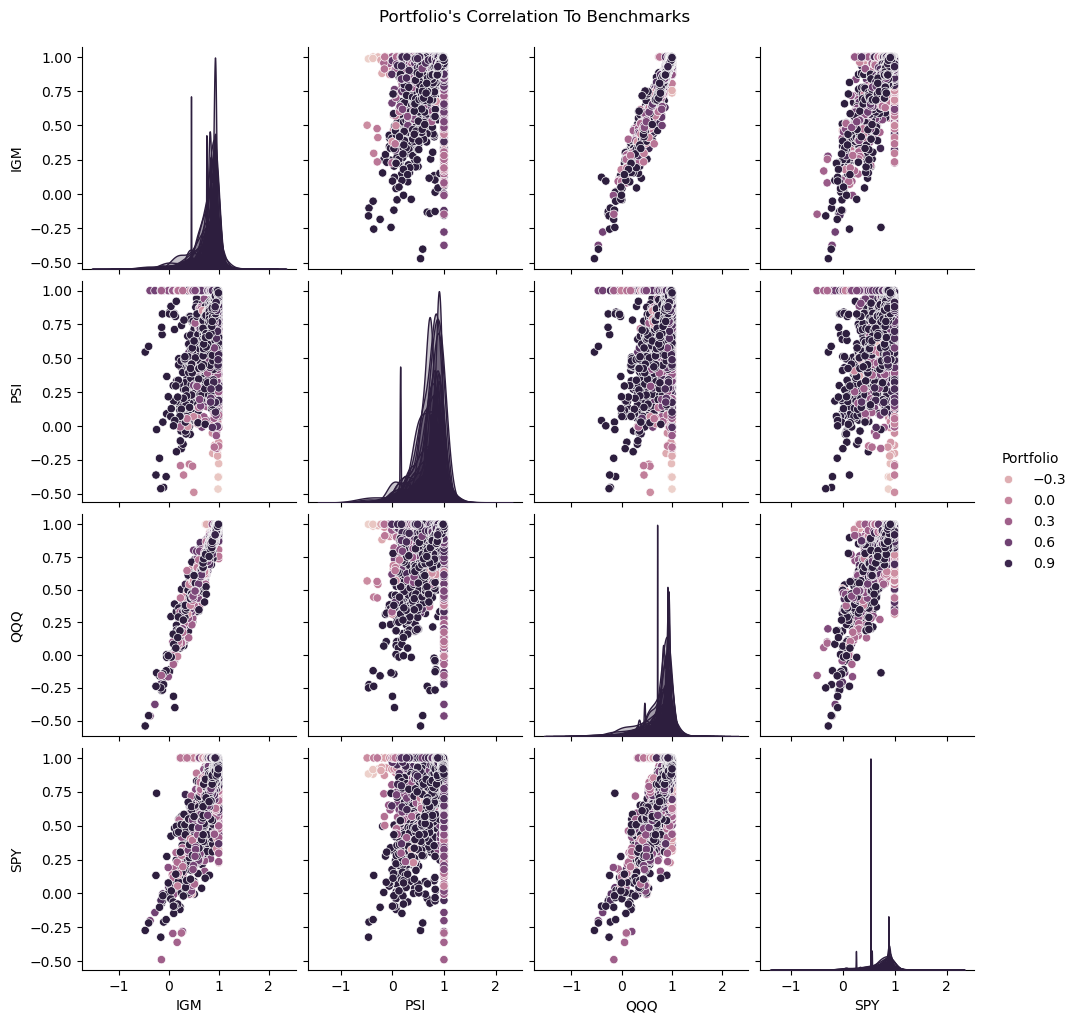

In [34]:
user_correlation_scatter_chart = CanaryFinancialCalculations.correlation_scatter_chart(user_rolling_correlation)
user_correlation_scatter_chart

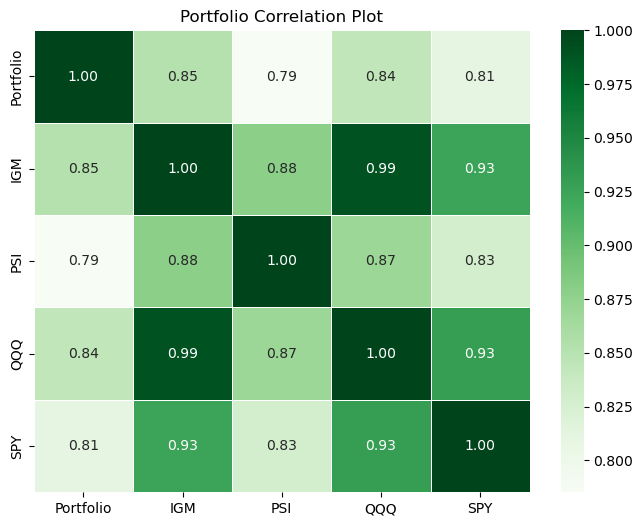

In [35]:
user_correlation_heatmap = CanaryFinancialCalculations.correlation_heatmap(user_correlation)
user_correlation_heatmap